## Important Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

sns.set()

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import metrics

## Scraped Datasets

### Loading Scraped Datasets

In [2]:
df_1 = pd.read_csv("BOM_CCU.csv")
df_2 = pd.read_csv("BOM_DEL.csv")
df_3 = pd.read_csv("BOM_MAA.csv")
df_4 = pd.read_csv("CCU_BOM.csv")
df_5 = pd.read_csv("CCU_DEL.csv")
df_6 = pd.read_csv("CCU_MAA.csv")
df_7 = pd.read_csv("DEL_BOM.csv")
df_8 = pd.read_csv("DEL_CCU.csv")
df_9 = pd.read_csv("DEL_MAA.csv")
df_10 = pd.read_csv("MAA_BOM.csv")
df_11 = pd.read_csv("MAA_CCU.csv")
df_12 = pd.read_csv("MAA_DEL.csv")

In [3]:
print(f"{df_1['Source'][0]} => {df_1['Destination'][0]} route has {df_1.shape[0]} trips")
print(f"{df_2['Source'][0]} => {df_2['Destination'][0]} route has {df_2.shape[0]} trips")
print(f"{df_3['Source'][0]} => {df_3['Destination'][0]} route has {df_4.shape[0]} trips")
print(f"{df_4['Source'][0]} => {df_4['Destination'][0]} route has {df_5.shape[0]} trips")
print(f"{df_5['Source'][0]} => {df_5['Destination'][0]} route has {df_7.shape[0]} trips")
print(f"{df_6['Source'][0]} => {df_6['Destination'][0]} route has {df_8.shape[0]} trips")
print(f"{df_7['Source'][0]} => {df_7['Destination'][0]} route has {df_10.shape[0]} trips")
print(f"{df_8['Source'][0]} => {df_8['Destination'][0]} route has {df_11.shape[0]} trips")
print(f"{df_9['Source'][0]} => {df_8['Destination'][0]} route has {df_11.shape[0]} trips")
print(f"{df_10['Source'][0]} => {df_8['Destination'][0]} route has {df_11.shape[0]} trips")
print(f"{df_11['Source'][0]} => {df_8['Destination'][0]} route has {df_11.shape[0]} trips")
print(f"{df_12['Source'][0]} => {df_8['Destination'][0]} route has {df_11.shape[0]} trips")

BOM => CCU route has 74 trips
BOM => DEL route has 118 trips
BOM => MAA route has 84 trips
CCU => BOM route has 127 trips
CCU => DEL route has 126 trips
CCU => MAA route has 127 trips
DEL => BOM route has 124 trips
DEL => CCU route has 107 trips
DEL => CCU route has 107 trips
MAA => CCU route has 107 trips
MAA => CCU route has 107 trips
MAA => CCU route has 107 trips


### Defining Function to clean Data

In [4]:
# convert duration to numerical format in minutes
def clean_duration(duration):
    duration = list(duration)
    duration_hours = []
    duration_mins = []
    for i in range(len(duration)):
        duration_hours.append(int(duration[i].split(sep = "h")[0])) # Extract hours from duration
        duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1])) # Extracts only minutes from duration

    d = []
    for i in range(len(duration)):
        d.append(duration_hours[i]*60+duration_mins[i])
        
    return d

# convert price to numerical format in INR
def clean_price(price):
    price = price.str.replace(',','',regex=True)
    price = price.str.replace('SAR','',regex=True)
    price = price.str.strip()
    price = round(pd.to_numeric(price)*21.64,2)
    return price

# convert date to datetime format
def clean_date(date):
    date = pd.to_datetime(date)
    return date

# get price quantile to deal with outliers
def get_price_quantile(price):
    Q1 = price.quantile(0.25)
    Q3 = price.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    return (lower_lim,upper_lim)

# get average of each airline
def get_avg_per_airline(x):
    # average for trips with multiple airlines
    multiple_airlines = x[x["Airline"].str.contains(",")]
    b = list(multiple_airlines["Airline"].str.split(","))
    d = [] # Airline 1
    e = [] # Airline 2
    for i in range(len(b)):
        d.append(b[i][0])
        e.append(b[i][1])
    for i in range(len(e)):
        e[i] = e[i].strip()
    m_airlines = list(set(d)) + list(set(e))
    column_names = ["Airline", "Average Price"]
    t_ = pd.DataFrame(columns = column_names)
    for airline in m_airlines:
        t = pd.DataFrame(x[x["Airline"].str.contains(airline)]["Airline"])
        t["Average Price"] = x[x["Airline"].str.contains(airline)]["Price"].mean()
        t_ = t_.append(t)
    t__ = t_.groupby("Airline",as_index = False)["Average Price"].mean()
    k = multiple_airlines.copy()
    k = k.merge(t__, on = "Airline", how = "left")
    
    # average for trips with single airlines
    single_airlines = x[~x["Airline"].str.contains(",")]
    avg_per_airline = single_airlines.groupby("Airline", as_index = False)["Price"].mean()
    avg_per_airline = avg_per_airline.rename(columns={"Price" : "Average Price"})
    temp = single_airlines.copy()
    temp = temp.merge(avg_per_airline, on='Airline', how ="left")
    
    temp_1 = temp.groupby("Airline", as_index = False)["Average Price"].mean()
    k_1 = k.groupby("Airline", as_index = False)["Average Price"].mean()
    k_temp = pd.concat([k_1,temp_1])
    y = x.merge(k_temp, on = "Airline")
    
    return y

In [5]:
dfs_raw = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12]

In [6]:
# cleaning the data
count = 0
dfs = []
for df in dfs_raw:
    count+=1
    print(count)
    df.drop_duplicates() # drop duplicate rows
    df["Duration"] = clean_duration(df["Duration"]) # convert duration to numerical minutes format
    df["Price"] = clean_price(df["Price"]) # convert price to numerical format in USD
    df["Date"] = clean_date(df["Date"]) # convert date to datetime format
    dfs.append(get_avg_per_airline(df)) # get average per airline


1
2
3
4
5
6
7
8
9
10
11
12


### BoxPlot For Outliers

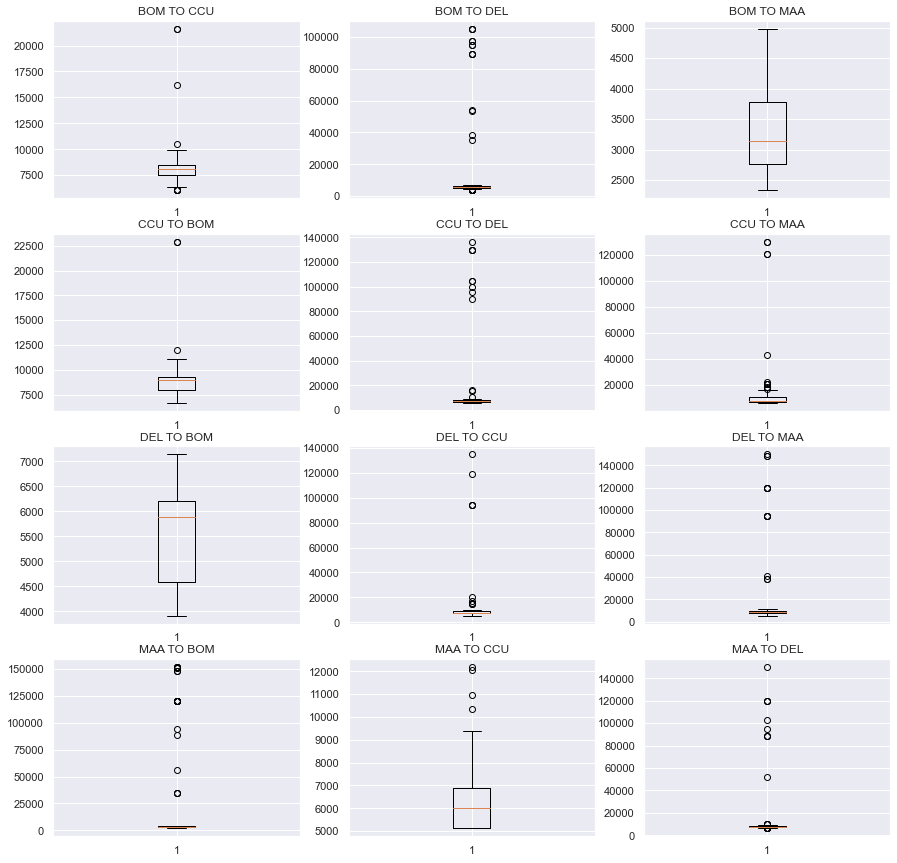

In [7]:
# boxplots for each route
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

In [8]:
# get quantile to deal with outliers
lower = []
upper = []
for df in dfs:
    x = get_price_quantile(df['Price'])
    lower.append(x[0])
    upper.append(x[1])

In [9]:
# drop outliers
k = 0
for df in dfs:
    low = df['Price'] < lower[k]
    up = df['Price'] > upper[k]
    df['Price'] = df['Price'][~(low|up)]
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace=True)
    k+=1

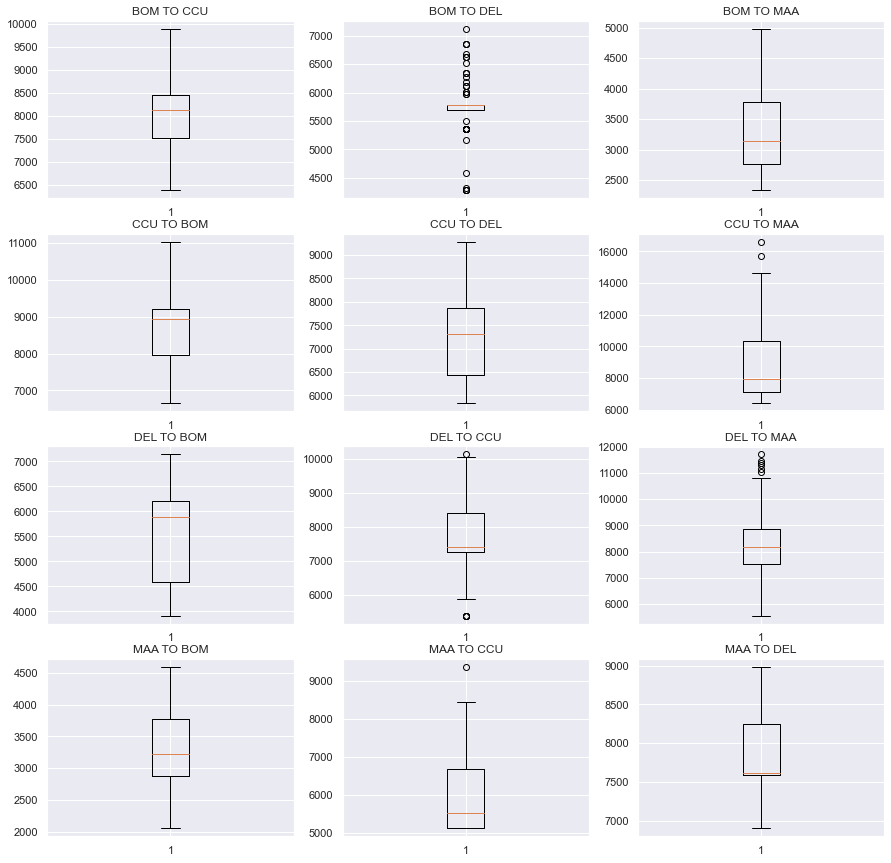

In [10]:
# boxplot for each route after dealing with outliers
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

In [11]:
# concat all routes into one dataframe
df = pd.concat(dfs)
df

,Airline,Source,Destination,Duration,Total stops,Price,Date,Average Price
0,Air India,BOM,CCU,185,nonstop,8201.56,2022-07-12,7798.723077
1,Air India,BOM,CCU,185,nonstop,7509.08,2022-07-12,7798.723077
2,Air India,BOM,CCU,165,nonstop,8201.56,2022-08-12,7798.723077
3,Air India,BOM,CCU,165,nonstop,7509.08,2022-08-12,7798.723077
4,Air India,BOM,CCU,185,nonstop,7509.08,2022-08-12,7798.723077
...,...,...,...,...,...,...,...,...
108,IndiGo,MAA,DEL,175,nonstop,7530.72,2022-12-14,7859.167111
109,IndiGo,MAA,DEL,175,nonstop,7530.72,2022-12-14,7859.167111
110,IndiGo,MAA,DEL,170,nonstop,8158.28,2022-12-14,7859.167111
111,IndiGo,MAA,DEL,185,nonstop,7530.72,2022-12-14,7859.167111


In [12]:
# check for null values
df.isnull().sum()

Airline          0
Source           0
Destination      0
Duration         0
Total stops      0
Price            0
Date             0
Average Price    0
dtype: int64

### Handling Categorical Data

In [13]:
# the Airline column will be replaced by the average price per airline.
df.drop("Airline", axis = 1, inplace = True)

In [14]:
# source
df["Source"].value_counts()

DEL    355
MAA    318
CCU    313
BOM    288
Name: Source, dtype: int64

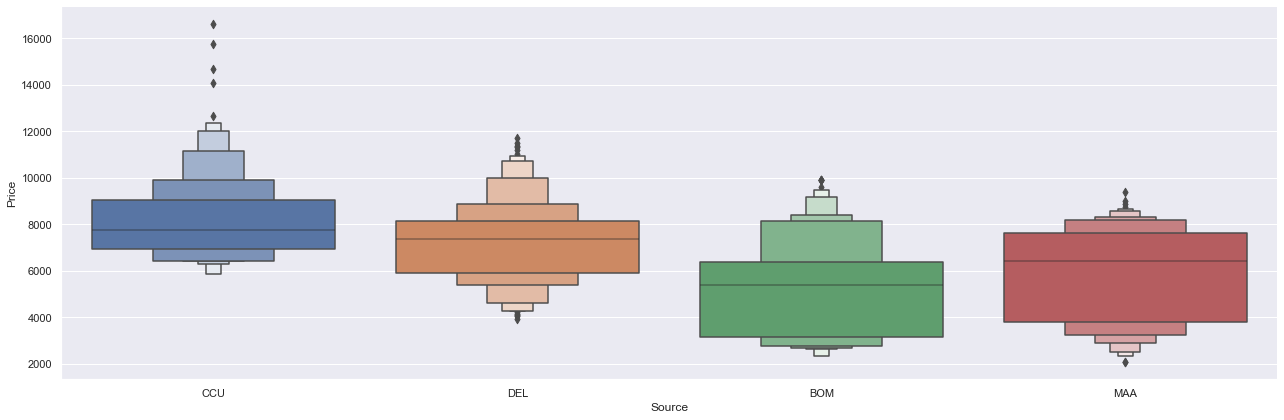

In [15]:
# source vs price
sns.catplot(y = "Price", x= "Source", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [16]:
# performing OneHotEncoding on Source since it's nominal categorical data  
source =df[["Source"]]
source =pd.get_dummies(source, drop_first=True)
source.head()

,Source_CCU,Source_DEL,Source_MAA
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [17]:
# destination
df["Destination"].value_counts()

MAA    364
DEL    316
BOM    309
CCU    285
Name: Destination, dtype: int64

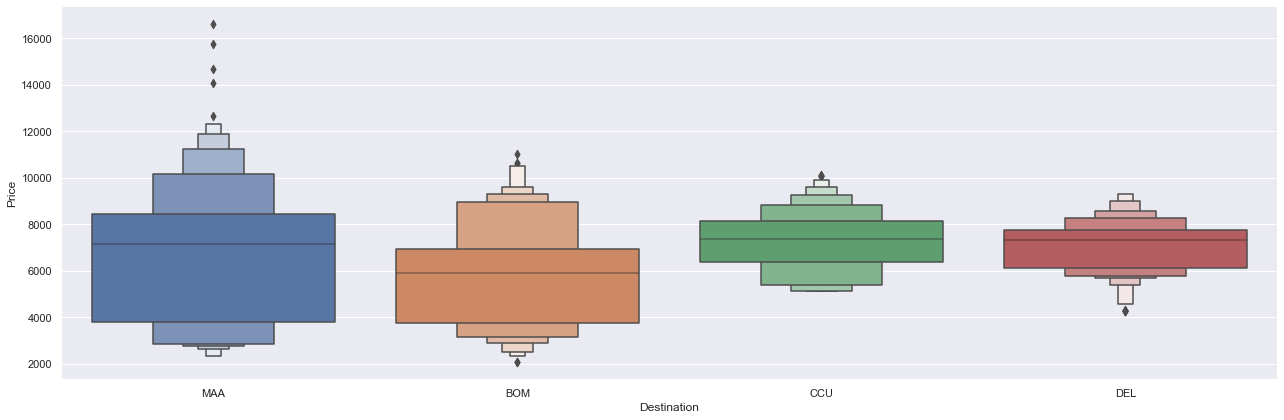

In [18]:
# destination vs price
sns.catplot(y = "Price", x= "Destination", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [19]:
# performing OneHotEncoding on Destination since it's nominal categorical data
destination = df[["Destination"]]
destination = pd.get_dummies(destination, drop_first=True)
destination.head()

,Destination_CCU,Destination_DEL,Destination_MAA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [20]:
# total stops
print(df["Total stops"].value_counts())
df["Total stops"].unique()

nonstop     1107
1 stop       164
2 stops        3
Name: Total stops, dtype: int64


array(['nonstop ', '1 stop ', '2 stops '], dtype=object)

In [21]:
# performing LabelEncoder on Total stops since it's ordinal categorical data
df.replace({"nonstop ":0, "1 stop ": 1, "2 stops ": 2, "3 stops ":3}, inplace=True)

In [22]:
final_df = pd.concat([df,source,destination], axis=1).reset_index(drop = True)

In [23]:
final_df

,Source,Destination,Duration,Total stops,Price,Date,Average Price,Source_CCU,Source_DEL,Source_MAA,Destination_CCU,Destination_DEL,Destination_MAA
0,BOM,CCU,185,0,8201.56,2022-07-12,7798.723077,0,0,0,1,0,0
1,BOM,CCU,185,0,7509.08,2022-07-12,7798.723077,0,0,0,1,0,0
2,BOM,CCU,165,0,8201.56,2022-08-12,7798.723077,0,0,0,1,0,0
3,BOM,CCU,165,0,7509.08,2022-08-12,7798.723077,0,0,0,1,0,0
4,BOM,CCU,185,0,7509.08,2022-08-12,7798.723077,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,MAA,DEL,175,0,7530.72,2022-12-14,7859.167111,0,0,1,0,1,0
1270,MAA,DEL,175,0,7530.72,2022-12-14,7859.167111,0,0,1,0,1,0
1271,MAA,DEL,170,0,8158.28,2022-12-14,7859.167111,0,0,1,0,1,0
1272,MAA,DEL,185,0,7530.72,2022-12-14,7859.167111,0,0,1,0,1,0


In [24]:
# drop date since it'll not be used as a feature
final_df.drop(["Source","Destination","Date"], axis=1, inplace=True)

In [25]:
final_df

,Duration,Total stops,Price,Average Price,Source_CCU,Source_DEL,Source_MAA,Destination_CCU,Destination_DEL,Destination_MAA
0,185,0,8201.56,7798.723077,0,0,0,1,0,0
1,185,0,7509.08,7798.723077,0,0,0,1,0,0
2,165,0,8201.56,7798.723077,0,0,0,1,0,0
3,165,0,7509.08,7798.723077,0,0,0,1,0,0
4,185,0,7509.08,7798.723077,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1269,175,0,7530.72,7859.167111,0,0,1,0,1,0
1270,175,0,7530.72,7859.167111,0,0,1,0,1,0
1271,170,0,8158.28,7859.167111,0,0,1,0,1,0
1272,185,0,7530.72,7859.167111,0,0,1,0,1,0


In [26]:
final_df.shape

(1274, 10)

In [27]:
final_df.isnull().sum()

Duration           0
Total stops        0
Price              0
Average Price      0
Source_CCU         0
Source_DEL         0
Source_MAA         0
Destination_CCU    0
Destination_DEL    0
Destination_MAA    0
dtype: int64

# Features

#### After constructing the final dataframe with all numerical values, now we can analyze the features that will be used for the regressions models

In [28]:
final_df.columns

Index(['Duration', 'Total stops', 'Price', 'Average Price', 'Source_CCU',
       'Source_DEL', 'Source_MAA', 'Destination_CCU', 'Destination_DEL',
       'Destination_MAA'],
      dtype='object')

In [29]:
X = final_df[['Duration', 'Total stops', 'Average Price',
       'Source_CCU', 'Source_DEL','Source_MAA' ,'Destination_CCU', 'Destination_DEL','Destination_MAA']]

y = final_df["Price"]

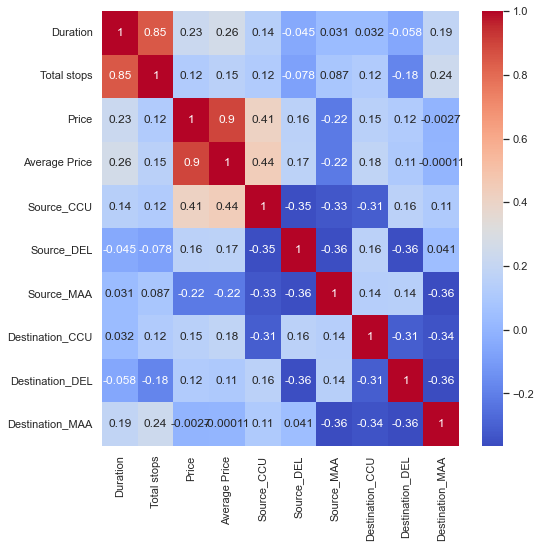

In [58]:
plt.figure(figsize = (8,8))

sns.heatmap(final_df.corr(),annot= True, cmap = "coolwarm")

plt.show()

In [31]:
# getting feature importance to the target variable "Price".
selection =ExtraTreesRegressor()
selection.fit(X,y)
selection.feature_importances_

array([0.06805055, 0.02793724, 0.63152709, 0.12198146, 0.04836047,
       0.00607985, 0.02328687, 0.02621943, 0.04655704])

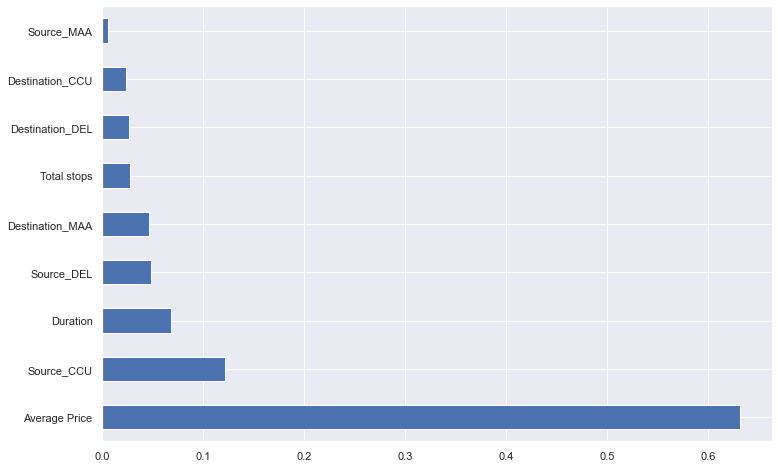

In [32]:
# plotting graph of important features
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_,index = X.columns)
feat_importances.nlargest(20).plot(kind="barh")
plt.show()

## Modelling

### Splitting the data

In [33]:
# 60% Train - 20% Val - 20% Test

X_train_or, X_test, y_train_or, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size=0.25)

### Defining a function to get metrics for val set

In [34]:
def get_metrics(model):
    print(f'Train score {model.score(X_train, y_train)}')
    print(f'Val score {model.score(X_val, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val))))

### Baseline Linear Regression

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)
score = lr.score(X_val, y_val)
get_metrics(lr)

Train score 0.8364417071089952
Val score 0.7239441203976347
MAE: 707.9231608620246
MSE: 1387344.9934605276
RMSE: 1177.8561004895835


### Polynomial 

In [36]:
for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("-"*20)
    print("Degree", degree)
    get_metrics(poly)

--------------------
Degree 1
Train score 0.8364417071089952
Val score 0.7239441203976344
MAE: 707.9231608620236
MSE: 1387344.993460529
RMSE: 1177.856100489584
--------------------
Degree 2
Train score 0.8670681679506083
Val score 0.7881731283704589
MAE: 644.370955485528
MSE: 1064556.0248850845
RMSE: 1031.7732429584926
--------------------
Degree 3
Train score 0.8970931598333979
Val score -128.18408443475812
MAE: 2637.200066886663
MSE: 649226863.1753064
RMSE: 25479.93059596722
--------------------
Degree 4
Train score 0.9009610642650153
Val score -975.1458831125387
MAE: 6808.970763155158
MSE: 4905713675.702064
RMSE: 70040.8000789687
--------------------
Degree 5
Train score 0.9046451794185826
Val score -252.56330092207128
MAE: 4504.378804997782
MSE: 1274306406.9719114
RMSE: 35697.42857646628


### Lasso

In [37]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
get_metrics(lasso_model)

Train score 0.8364142983650408
Val score 0.7232894734202764
MAE: 707.1451902178464
MSE: 1390634.9839067743
RMSE: 1179.2518746674834


### Ridge

In [38]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
get_metrics(ridge_model)

Train score 0.8364403584534688
Val score 0.7238216467966605
MAE: 707.9228840619029
MSE: 1387960.4961529078
RMSE: 1178.1173524538665


### ElasticNet

In [39]:
EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train, y_train)
EN_model.score(X_val, y_val)
get_metrics(EN_model)

Train score 0.8352313927176611
Val score 0.720384023411054
MAE: 711.0901877445525
MSE: 1405236.5983692182
RMSE: 1185.4267579100863


### Random Forest Classifier

In [40]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
get_metrics(rf)

Train score 0.9306588865717303
Val score 0.8105352800329884
MAE: 580.3986229113293
MSE: 952172.9117389253
RMSE: 975.7934780161862


### Feature Scaling

In [41]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [42]:
# function to get metrics for scaled features
def scaled_metrics(model):
    print(f'Train score {model.score(X_train_scaled, y_train)}')
    print(f'Val score {model.score(X_val_scaled, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val_scaled)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val_scaled)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val_scaled))))

    
## Baseline: Linear Regression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
score = lr.score(X_val_scaled, y_val)
print("LR")
scaled_metrics(lr)
print("-"*50)

## Polynomial

for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("Polynomial - Degree", degree)
    scaled_metrics(poly)
    print("-"*50)

## Lasso

lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
print("Lasso")
scaled_metrics(lasso_model)
print("-"*50)

## Ridge

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
print("Ridge")
scaled_metrics(ridge_model)
print("-"*50)

## ElasticNet

EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train_scaled, y_train)
EN_model.score(X_val_scaled, y_val)
print("ElasticNet")
scaled_metrics(EN_model)
print("-"*50)

## Random Forest
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
print("Random Forest")
scaled_metrics(rf)

LR
Train score 0.8364417071089952
Val score 0.723944120397634
MAE: 707.9231608620236
MSE: 1387344.9934605309
RMSE: 1177.8561004895848
--------------------------------------------------
Polynomial - Degree 1
Train score -8.673791835166965
Val score -8.21876201978772
MAE: 6427.631019783859
MSE: 46329762.483156934
RMSE: 6806.596982571903
--------------------------------------------------
Polynomial - Degree 2
Train score -23.656262955762898
Val score -20.24174439398308
MAE: 7947.506672257326
MSE: 106752400.20176026
RMSE: 10332.105313137312
--------------------------------------------------
Polynomial - Degree 3
Train score -314176.4198896982
Val score -161608.28233253837
MAE: 474661.26974045835
MSE: 812182769168.8655
RMSE: 901211.8336822179
--------------------------------------------------


c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid featu

Polynomial - Degree 4
Train score -743.4374860756762
Val score -700.147804266484
MAE: 59323.25503025474
MSE: 3523684760.223501
RMSE: 59360.63308475998
--------------------------------------------------


c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid featu

Polynomial - Degree 5
Train score -10.069739508788937
Val score -9.517506839927881
MAE: 6916.0019369995425
MSE: 52856727.69976305
RMSE: 7270.263248312474
--------------------------------------------------
Lasso
Train score 0.8364371745445791
Val score 0.7238074946796924
MAE: 707.7514660433526
MSE: 1388031.6189583729
RMSE: 1178.1475370081512
--------------------------------------------------
Ridge
Train score 0.836438815718306
Val score 0.7243504749836323
MAE: 708.1774817700123
MSE: 1385302.8199655616
RMSE: 1176.988878437499
--------------------------------------------------
ElasticNet
Train score 0.755928530059562
Val score 0.6955417586983894
MAE: 897.1222270218343
MSE: 1530083.754767336
RMSE: 1236.965543080055
--------------------------------------------------


c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid featu

Random Forest
Train score -3.6607354114291732
Val score -3.46567364450722
MAE: 4180.86242666667
MSE: 22442666.25315027
RMSE: 4737.369127812426


c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\users\shantanu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have

#### Feature scaling was of no use, it did not improve anything

**<br>From the above analysis, we can see that the random forest model performed the best with:</br>**

**<br>Train score 0.9306588865717303</br>**
**<br>Val score 0.81053528003298843</br>**
**<br>MAE: 580.3986229113293</br>**
**<br>MSE: 952172.9117389253</br>**
**<br>RMSE: 975.7934780161862</br>**

**So, we'll select it as our model.**

In [43]:
# retraining the random forest model on train + val, and scoring on test

X_train_val = pd.concat([X_train,X_val])
y_train_val = pd.concat([y_train,y_val])

rf = RandomForestRegressor()
rf.fit(X_train_val,y_train_val)

print(f'Train score {rf.score(X_train_val, y_train_val)}')
print(f'Test score {rf.score(X_test, y_test)}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf.predict(X_test))))

Train score 0.910982969610942
Test score 0.8614793041616288
MAE: 475.3232330311561
MSE: 571583.4851074062
RMSE: 756.0314048420252


In [44]:
y_train_val_pred = rf.predict(X_train_val)
y_test_pred = rf.predict(X_test)

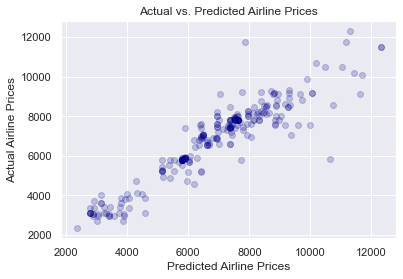

In [45]:
plt.scatter(y_test,y_test_pred,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

### Hyperparameter Tuning

In [46]:
# randomized search CV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [47]:
# create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [48]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, n_jobs = 1)

In [49]:
rf_random.fit(X_train_val,y_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=600; total time=   0.7s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=600; total time=   0.7s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=600; total time=   0.7s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=600; total time=   0.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=600; total time=   0.6s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.5s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.4s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimat

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='neg_mean_squared_error', verbose=2)

In [50]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 25}

In [51]:
prediction = rf_random.predict(X_test)

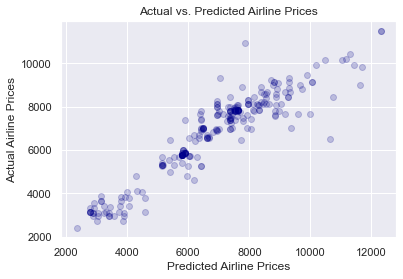

In [52]:
plt.scatter(y_test,prediction,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

In [53]:
print("MAE:" , metrics.mean_absolute_error(y_test,prediction))
print("MSE:" , metrics.mean_squared_error(y_test,prediction))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,prediction)))

MAE: 487.6588205878737
MSE: 542926.7712993954
RMSE: 736.835647413584


#### Therefore, hyperparameter tuning did not improve the model

In [54]:
test_df = pd.DataFrame({
    "Predicted Price" : rf.predict(X_test),
    "Actual Price" : y_test,
}).reset_index(drop = True)

test_df

,Predicted Price,Actual Price
0,2945.264179,2878.12
1,5896.074292,6275.60
2,6570.101383,6362.16
3,2945.264179,3051.24
4,7834.352415,8309.76
...,...,...
250,8837.087678,8915.68
251,7560.378071,7314.32
252,7301.471924,7790.40
253,3415.064657,3224.36


## Saving The Final Model: <a class="anchor" id="model"></a>

In [55]:
# save the model
file = open('rf_flight_prediction.pkl', 'wb')
pkl.dump(rf, file)

In [56]:
# open the model
model = open('rf_flight_prediction.pkl','rb')
rf_flight_prediction = pkl.load(model)

In [57]:
print(f'R2 score {metrics.r2_score(y_test,rf_flight_prediction.predict(X_test))}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf_flight_prediction.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf_flight_prediction.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf_flight_prediction.predict(X_test))))

R2 score 0.8614793041616288
MAE: 475.3232330311561
MSE: 571583.4851074062
RMSE: 756.0314048420252


### Therefore, the final model is able to predict flight ticket prices within around  ≈ 499 INR